In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Scale and crop the images to 1520*870

In [ ]:
from PIL import Image
import os

# Define the required minimum dimensions and crop dimensions
min_width = 1520
min_height = 870
crop_width = 1520
crop_height = 870

# Function to resize and crop the image while maintaining aspect ratio
def resize_and_crop_image(image_path, output_path):
    with Image.open(image_path) as img:
        original_width, original_height = img.size

        # Calculate the scale factor to meet the minimum requirements
        scale_factor = max(min_width / original_width, min_height / original_height)

        # Calculate the new dimensions
        new_width = int(original_width * scale_factor)
        new_height = int(original_height * scale_factor)

        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)

        # Calculate coordinates to crop the image to the center
        left = (new_width - crop_width) / 2
        top = (new_height - crop_height) / 2
        right = (new_width + crop_width) / 2
        bottom = (new_height + crop_height) / 2

        # Crop the image
        cropped_img = resized_img.crop((left, top, right, bottom))

        # Save the cropped image
        cropped_img.save(output_path)
        print(f"Resized and cropped image saved as: {output_path}")

# Define the input and output directories
input_dir = '/content/drive/MyDrive/TIL_personal/extra_data'
output_dir = '/content/drive/MyDrive/TIL_personal/extra_data_scaled'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        resize_and_crop_image(input_path, output_path)

<ipython-input-2-857a1beea478>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)


Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000628_(3).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000632_(3).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000628_(2).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000631_(2).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000630.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000634.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000628.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000629.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/extra_data_scaled/00000630_(2).jpg
Resized and cropped image saved as: /content/drive/My

#Add targets and bboxes

In [ ]:
import os
import random
import json
import re
from PIL import Image

# Directories for the images
big_images_dir = '/content/drive/MyDrive/TIL_personal/background_dataset_scaled'
small_images_dir = '/content/drive/MyDrive/TIL_personal/images_no_background'
output_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

def normalize_filename(filename):
    # Remove the file extension
    base_name = os.path.splitext(filename)[0]
    # Remove trailing numbers and underscores
    normalized_name = re.sub(r'[_\d]+$', '', base_name)
    return normalized_name

def get_unique_filenames(directory):
    all_files = os.listdir(directory)
    seen = set()
    unique_files = []

    for file in all_files:
        normalized_name = normalize_filename(file)
        if normalized_name not in seen:
            seen.add(normalized_name)
            unique_files.append(file)

    return unique_files

def check_overlap(bbox1, bbox2):
    left1, top1, width1, height1 = bbox1
    left2, top2, width2, height2 = bbox2

    right1 = left1 + width1
    bottom1 = top1 + height1
    right2 = left2 + width2
    bottom2 = top2 + height2

    return not (right1 <= left2 or right2 <= left1 or bottom1 <= top2 or bottom2 <= top1)

# Function to randomly select, rotate, resize and place small images
def process_images(big_image_path):
    with Image.open(big_image_path) as big_img:
        big_width, big_height = big_img.size

        annotations = []

        # Get the unique filenames
        unique_files = get_unique_filenames(small_images_dir)

        # Randomly sample 4 unique files
        small_images = random.sample(unique_files, 4)
        for small_image_filename in small_images:
            small_image_path = os.path.join(small_images_dir, small_image_filename)
            with Image.open(small_image_path) as small_img:
                # Rotate the small image
                angle = random.uniform(-180, 180)
                rotated_img = small_img.rotate(angle, expand=True)

                # Calculate scale factor and resize the rotated image
                scale_factor = random.uniform(0.03, 0.10)
                new_width = int(big_width * scale_factor)
                new_height = int(big_height * scale_factor)
                scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)

                while True:
                    # Randomly place the small image on the big image
                    max_left = int(0.9 * big_width) - new_width
                    max_top = int(0.9 * big_height) - new_height
                    left = random.randint(int(0.1 * big_width), max_left)
                    top = random.randint(int(0.1 * big_height), max_top)
                    bbox = [left, top, new_width, new_height]

                    # Check for overlap with existing annotations
                    overlap = False
                    for annotation in annotations:
                        if check_overlap(bbox, annotation["bbox"]):
                            overlap = True
                            break

                    if not overlap:
                        break

                big_img.paste(scaled_img, (left, top), scaled_img.convert("RGBA"))
                caption = small_image_filename[:-4].split('_')
                try:
                    int(caption[-1])
                    caption = caption[:-1]
                    caption = ' '.join(caption)
                except:
                    caption = ' '.join(caption)
                #print(caption)
                # Record the annotation
                annotation = {
                    "caption": caption,
                    "bbox": [left, top, new_width, new_height]
                }
                annotations.append(annotation)

        # Save the new image
        output_image_path = os.path.join(output_dir, os.path.basename(big_image_path))
        big_img.save(output_image_path)

        return os.path.basename(big_image_path), annotations

# Process each big image and collect annotations
all_annotations = []
for big_image_filename in os.listdir(big_images_dir):
    if big_image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        big_image_path = os.path.join(big_images_dir, big_image_filename)
        image_name, annotations = process_images(big_image_path)
        all_annotations.append({
            "image": image_name,
            "annotations": annotations
        })

# Save annotations to a JSON file
output_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/annotations.json')
with open(output_json_path, 'w') as json_file:
    json.dump(all_annotations, json_file, indent=4)

print(f"Annotations saved to {output_json_path}")

<ipython-input-2-f524911b1644>:69: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)


Annotations saved to /content/drive/MyDrive/TIL_personal/annotations.json


## Append extra targets and bboxes

In [ ]:
import os
import random
import json
from PIL import Image

# Directories for the images
big_images_dir = '/content/drive/MyDrive/TIL_personal/extra_data_scaled'
small_images_dir = '/content/drive/MyDrive/TIL_personal/images_no_background'
extra_images_dir = '/content/drive/MyDrive/TIL_personal/extra_images'
output_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to check for overlap between bounding boxes
def check_overlap(bbox1, bbox2):
    left1, top1, width1, height1 = bbox1
    left2, top2, width2, height2 = bbox2

    right1 = left1 + width1
    bottom1 = top1 + height1
    right2 = left2 + width2
    bottom2 = top2 + height2

    return not (right1 <= left2 or right2 <= left1 or bottom1 <= top2 or bottom2 <= top1)

# Function to randomly select, rotate, resize and place small images
def process_images(big_image_path, specific_image = ''):
    with Image.open(big_image_path) as big_img:
        big_width, big_height = big_img.size

        annotations = []
        small_images = []

        extra = False
        # List of small images ensuring 'specific_small_image.jpg' is included
        if specific_image == '':
            small_images = random.sample(os.listdir(extra_images_dir), 4)
            extra = True
        else:
            small_images = [specific_image] + random.sample(
                [img for img in os.listdir(small_images_dir)],
                3
            )

        for i, small_image_filename in enumerate(small_images):
            small_image_path = ''
            if extra:
                small_image_path = os.path.join(extra_images_dir, small_image_filename)
            else:
                if i == 0:
                    small_image_path = os.path.join(extra_images_dir, small_image_filename)
                else:
                    small_image_path = os.path.join(small_images_dir, small_image_filename)
            with Image.open(small_image_path) as small_img:
                # Rotate the small image
                angle = random.uniform(-180, 180)
                rotated_img = small_img.rotate(angle, expand=True)

                # Calculate scale factor and resize the rotated image
                scale_factor = random.uniform(0.03, 0.10)
                new_width = int(big_width * scale_factor)
                new_height = int(big_height * scale_factor)
                scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)

                # Ensure the image does not overlap with already placed images
                while True:
                    # Randomly place the small image on the big image
                    max_left = int(0.9 * big_width) - new_width
                    max_top = int(0.9 * big_height) - new_height
                    left = random.randint(int(0.1 * big_width), max_left)
                    top = random.randint(int(0.1 * big_height), max_top)
                    bbox = [left, top, new_width, new_height]

                    # Check for overlap with existing annotations
                    overlap = False
                    for annotation in annotations:
                        if check_overlap(bbox, annotation["bbox"]):
                            overlap = True
                            break

                    if not overlap:
                        break

                big_img.paste(scaled_img, (left, top), scaled_img.convert("RGBA"))
                caption = small_image_filename[:-4].split('_')
                try:
                    int(caption[-1])
                    caption = caption[:-1]
                    caption = ' '.join(caption)
                except:
                    caption = ' '.join(caption)
                # Record the annotation
                annotation = {
                    "caption": caption,
                    "bbox": [left, top, new_width, new_height]
                }
                annotations.append(annotation)

        # Save the new image
        output_image_path = os.path.join(output_dir, os.path.basename(big_image_path))
        big_img.save(output_image_path)

        return os.path.basename(big_image_path), annotations

# Process the first 100 big images and collect annotations
all_annotations = []
big_images = [img for img in os.listdir(big_images_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
for i, big_image_filename in enumerate(big_images[:100]):
    big_image_path = os.path.join(big_images_dir, big_image_filename)
    specific_image = ''
    if i < 15:
        specific_image = 'green_and_black_glider.png'
    elif i < 30:
        specific_image = 'grey_blue_and_yellow_blimp.png'
    elif i < 45:
        specific_image = 'white_and_black_airship.png'
    elif i < 60:
        specific_image = 'white_and_black_space_shuttle.png'
    elif i < 75:
        specific_image = 'white_blimp.png'
    elif i < 90:
        specific_image = 'white_glider.png'
    image_name, annotations = process_images(big_image_path, specific_image)
    all_annotations.append({
        "image": image_name,
        "annotations": annotations
    })
    print(f"Processed image {i+1}/100")

# Save annotations to a JSON file
output_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/annotations.json')

# Check if the file already exists
if os.path.exists(output_json_path):
    with open(output_json_path, 'r') as json_file:
        existing_data = json.load(json_file)
else:
    existing_data = []

# Append new data to the existing data
existing_data.extend(all_annotations)

with open(output_json_path, 'w') as json_file:
    json.dump(all_annotations, json_file, indent=4)

print(f"Annotations saved to {output_json_path}")

<ipython-input-5-4e0fa3583161>:64: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)


Processed image 1/100
Processed image 2/100
Processed image 3/100
Processed image 4/100
Processed image 5/100
Processed image 6/100
Processed image 7/100
Processed image 8/100
Processed image 9/100
Processed image 10/100
Processed image 11/100
Processed image 12/100
Processed image 13/100
Processed image 14/100
Processed image 15/100
Processed image 16/100
Processed image 17/100
Processed image 18/100
Processed image 19/100
Processed image 20/100
Processed image 21/100
Processed image 22/100
Processed image 23/100
Processed image 24/100
Processed image 25/100
Processed image 26/100
Processed image 27/100
Processed image 28/100
Processed image 29/100
Processed image 30/100
Processed image 31/100
Processed image 32/100
Processed image 33/100
Processed image 34/100
Processed image 35/100
Processed image 36/100
Processed image 37/100
Processed image 38/100
Processed image 39/100
Processed image 40/100
Processed image 41/100
Processed image 42/100
Processed image 43/100
Processed image 44/1

#Augment data

In [ ]:
import cv2
import numpy as np
import albumentations as A
import os

def add_noise_to_image(input_image_path, output_image_path):
    # Define mean and std for normalization (you might need to adjust these values)
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

    # Define the Albumentations transforms
    albu_transforms = A.Compose([
        A.GaussNoise(var_limit=500, p=0.5),
        A.ISONoise(p=0.5),
        A.MultiplicativeNoise(p=0.5),
        A.CLAHE(p=0.1),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.5, p=0.5),
        A.RandomGamma(p=0.2),
        A.ImageCompression(quality_lower=75, p=0.5),
        A.Normalize(mean=mean, std=std),
    ])

    # Read the input image
    image = cv2.imread(input_image_path)
    if image is None:
        raise FileNotFoundError(f"Input image not found: {input_image_path}")

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply the transformations
    augmented = albu_transforms(image=image)
    transformed_image = augmented['image']

    # Denormalize the image (convert it back to the original range)
    transformed_image = (transformed_image * std + mean) * 255
    transformed_image = np.clip(transformed_image, 0, 255).astype(np.uint8)

    # Convert the image back to BGR for saving with OpenCV
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)

    # Save the transformed image
    cv2.imwrite(output_image_path, transformed_image)
    print(f"Transformed image saved to: {output_image_path}")


input_image_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'
output_image_dir = '/content/drive/MyDrive/TIL_personal/images_augmented'
os.makedirs(output_image_dir, exist_ok=True)
for image_filename in os.listdir(input_image_dir):
    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        input_image_path = os.path.join(input_image_dir, image_filename)
        output_image_path = os.path.join(output_image_dir, image_filename)
        add_noise_to_image(input_image_path, output_image_path)
        print(f"Processed {image_filename}")

print("All images have been processed and saved.")

#Visualize bboxes

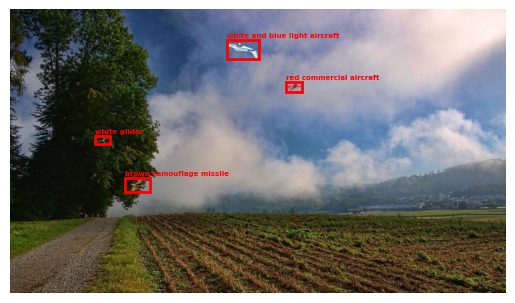

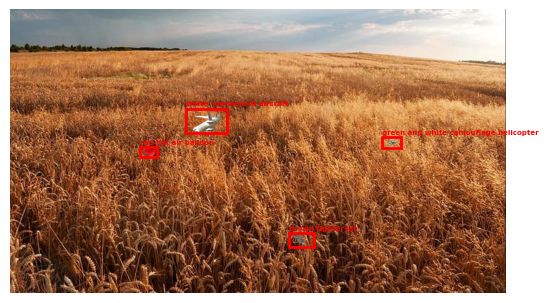

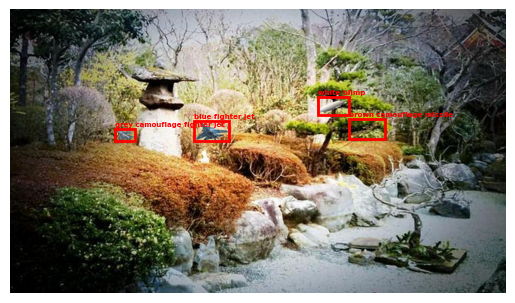

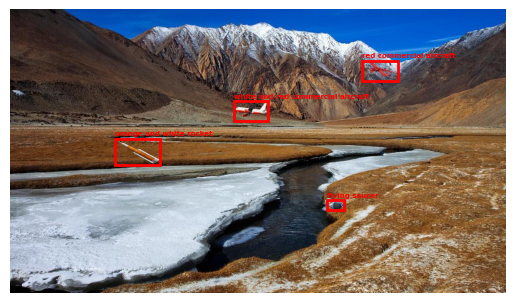

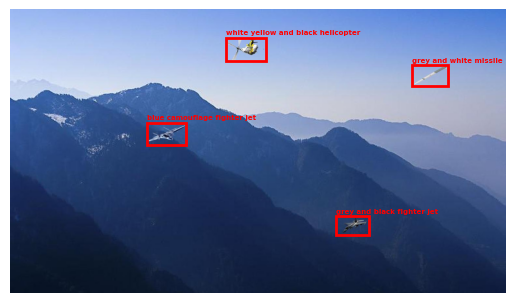

In [ ]:
import json
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths to the JSON file and the folder with the new images
annotations_json_path = '/content/drive/MyDrive/TIL_personal/annotations.json'
images_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Load the annotations from the JSON file
with open(annotations_json_path, 'r') as json_file:
    annotations_data = json.load(json_file)

# Select 5 random images
random_annotations = random.sample(annotations_data, 5)

# Function to display an image with bounding boxes
def show_image_with_bboxes(image_path, annotations):
    with Image.open(image_path) as img:
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for annotation in annotations:
            bbox = annotation['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1] - 10, annotation['caption'], color='red', fontsize=5, weight='bold')

        plt.axis('off')
        plt.show()

# Display the 5 selected images with their bounding boxes
for annotation in random_annotations:
    image_name = annotation['image']
    image_path = os.path.join(images_dir, image_name)
    show_image_with_bboxes(image_path, annotation['annotations'])